<a href="https://colab.research.google.com/github/Alex62CT/Monte-Carlo_Simulations/blob/main/MC_Versione_Contour_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

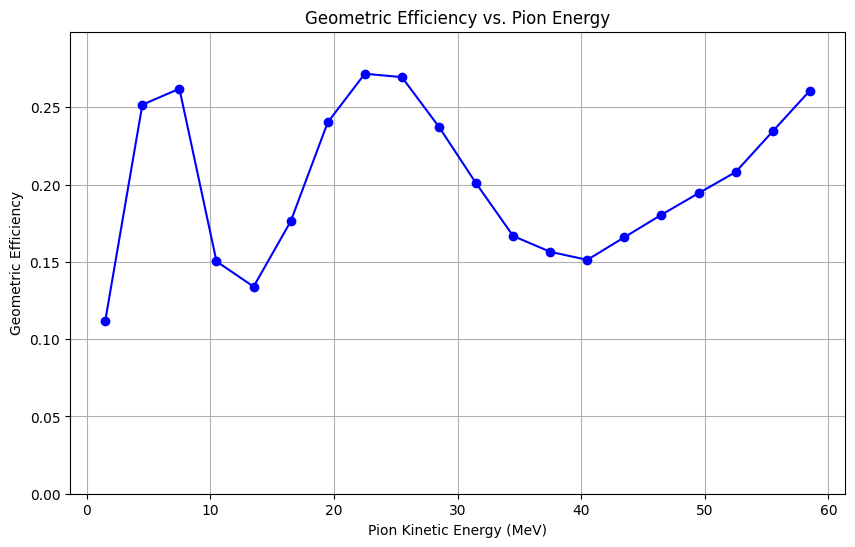

Geometric Efficiency: 0.2004
Fit Results (gaussian):
  Parameters: [6217.94219614  132.93750766   25.29363074]
  Errors: [9.96718345 0.04681727 0.04681727]
  Reduced Chi-squared: 7.67
  FWHM: 59.56 ± 0.11 MeV/c^2
Maximum of invariant mass spectrum: 135.00 MeV/c^2 +/- 25.66 MeV/c^2
Invariant mass spectrum variance: 658.32 (MeV/c^2)^2
Invariant mass spectrum skewness: -0.07


<ipython-input-15-be65b7bd432c>:279: RuntimeWarning: divide by zero encountered in divide
  chi_squared = np.sum(np.where(counts > 0, (residuals ** 2) / counts, 0))


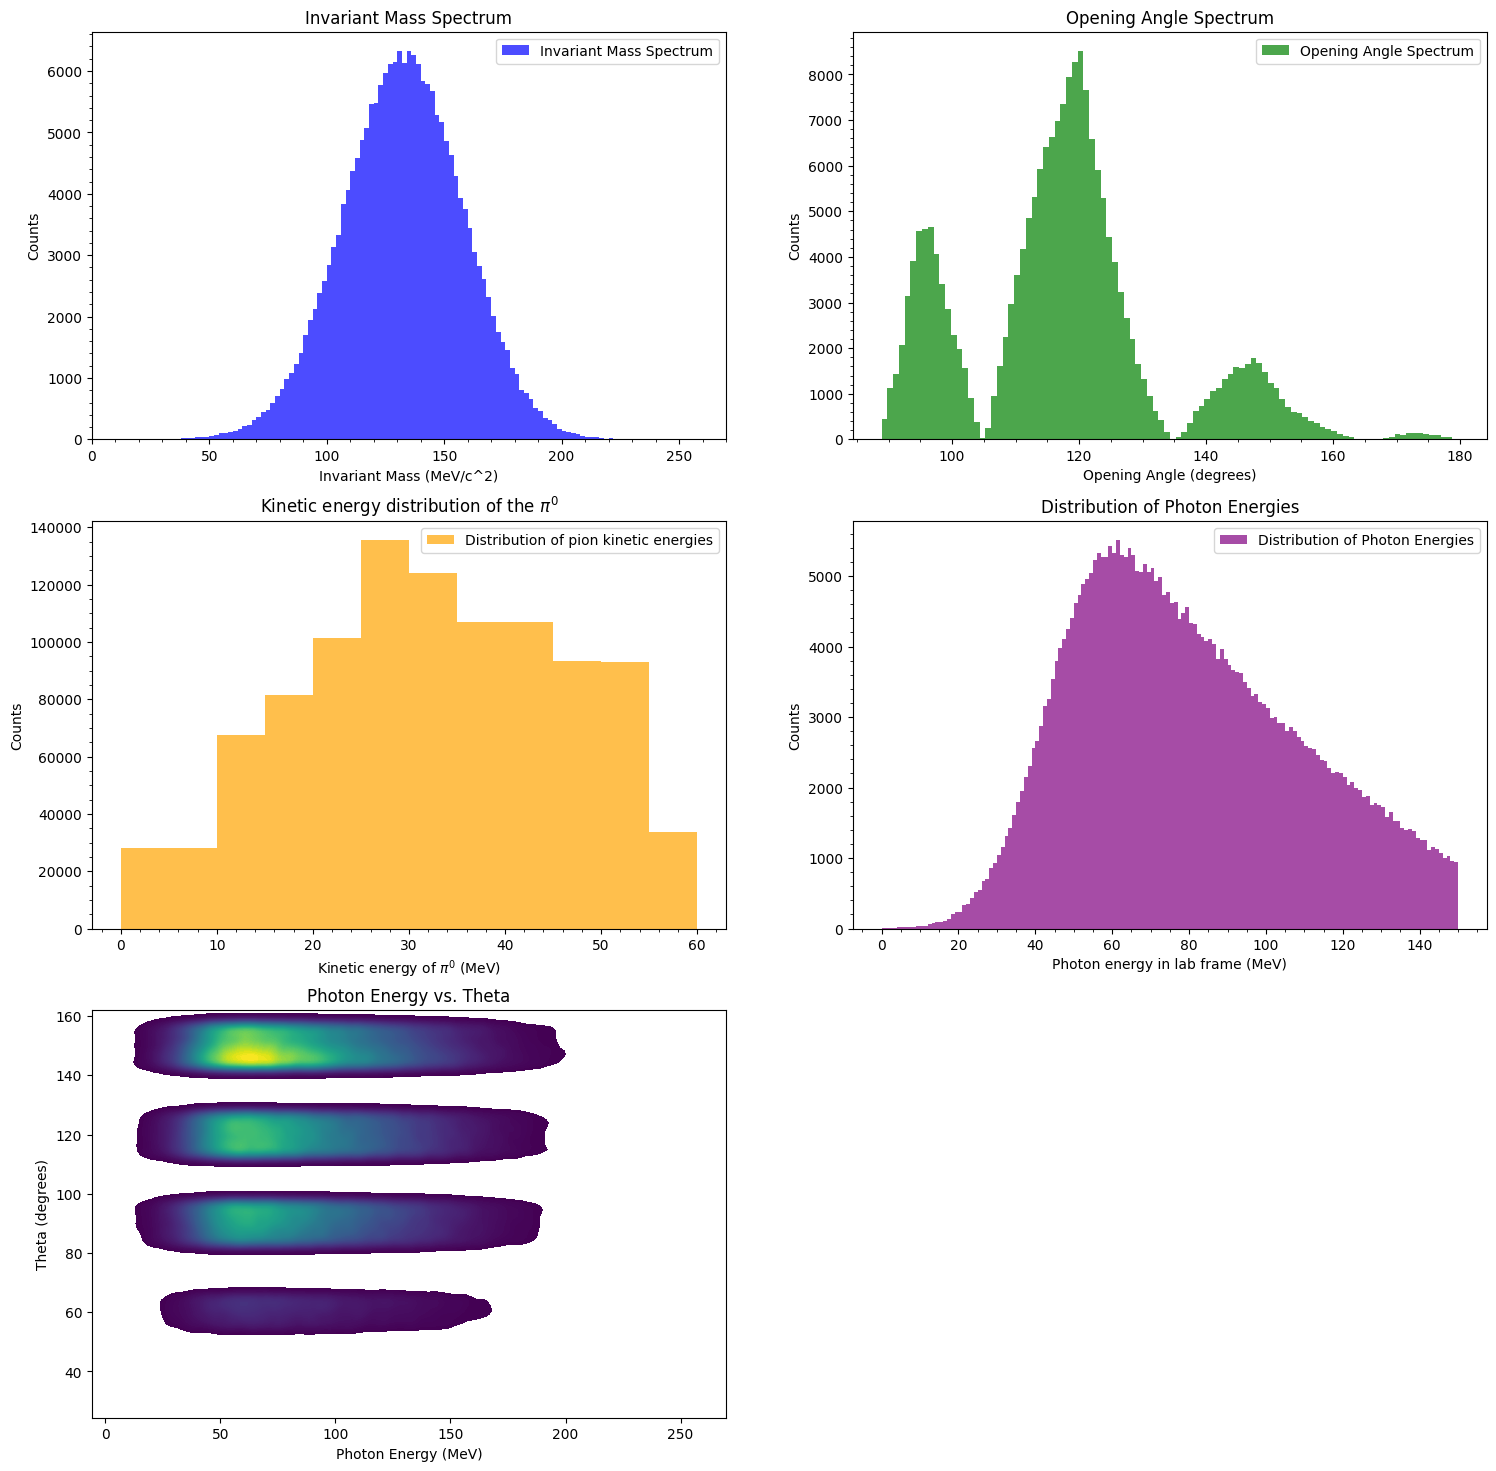

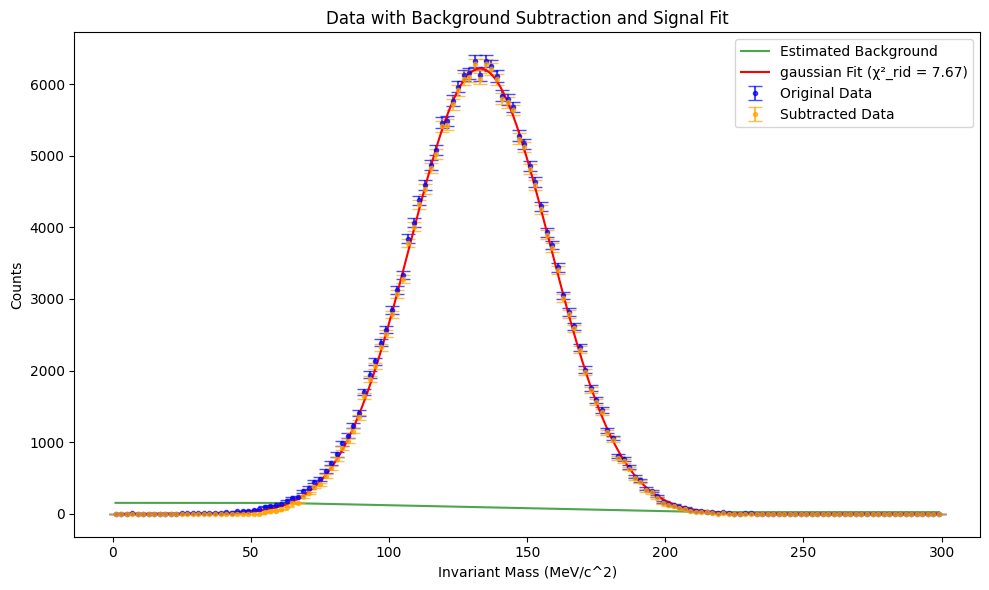

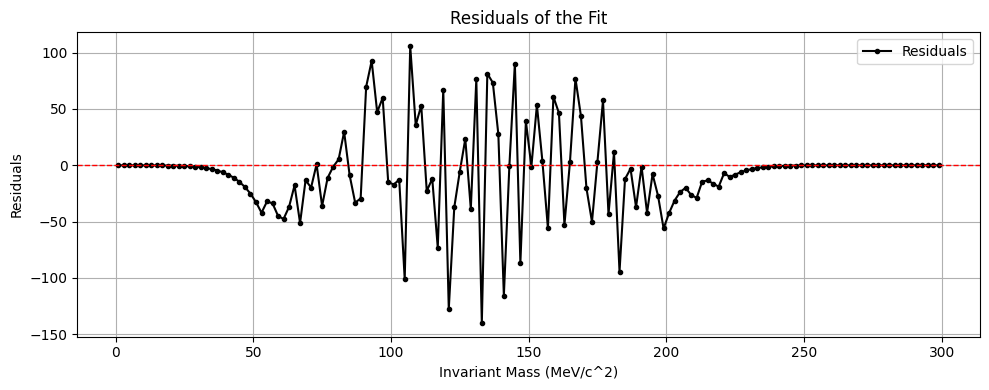

<Figure size 640x480 with 0 Axes>

In [ ]:
#VERSIONE CON COLORMAPPED SCATTER PLOT
import matplotlib.ticker as ticker
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.colors as mcolors #Importo il modulo colors
import seaborn as sns

# --- Costanti fisiche ---
M_PI0 = 134.9766  # MeV/c^2

# --- Funzioni di utilità (Numba-compatibili) ---

@jit(nopython=True)
def is_accepted(theta, phi, bounds):
    """Checks if a given angle is within the detector acceptance."""
    for i in range(bounds.shape[0]):
        phi_min, phi_max, theta_min, theta_max = bounds[i]
        if (phi_min <= phi <= phi_max) and (theta_min <= theta <= theta_max):
            return True
    return False

@jit(nopython=True)
def sample_isotropic_angles(num_samples):
    """Generates isotropic angles (cos(theta) and phi)."""
    cos_theta = np.random.uniform(-1, 1, num_samples)
    phi = np.random.uniform(0, 2 * np.pi, num_samples)
    return cos_theta, phi

@jit(nopython=True)
def boost_lab_frame(vectors, beta):
    """Boosts 4-vectors to the lab frame."""
    gamma = 1 / np.sqrt(1 - beta**2)
    if np.any(np.isinf(gamma)):
        print("Infinite gamma detected")
        gamma = np.where(np.isinf(gamma), 1e10, gamma)  # Replace inf with a large number
    boosted_vectors = np.empty_like(vectors)
    boosted_vectors[:, 0] = gamma * (vectors[:, 0] - beta * vectors[:, 3])
    boosted_vectors[:, 1] = vectors[:, 1]
    boosted_vectors[:, 2] = vectors[:, 2]
    boosted_vectors[:, 3] = gamma * (vectors[:, 3] - beta * vectors[:, 0])
    return boosted_vectors

@jit(nopython=True)
def energy_resolution(E, a=1.6806, b=-4.9133):
    """Calculates the detector energy resolution."""
    return  a * E + b

@jit(nopython=True)
def simulate_energy_calibration(E_gamma_true, E_gamma_min):
    """Simulates detector response and energy calibration."""
    alpha_1, alpha_2 = -5.8e-5, 0.154
    beta_1, beta_2 = 8.34e-5, 0.055
    b_0 = -0.3
    a_E = alpha_1 * E_gamma_true + alpha_2
    a_prime_E = beta_1 * E_gamma_true + beta_2

    if a_E <= 0:
        return E_gamma_true

    sigma_A = energy_resolution(E_gamma_true)
    sigma_C = energy_resolution(E_gamma_true)
    A = (E_gamma_true - a_prime_E * 50 - b_0) / a_E
    C = 50
    A_meas = A + np.random.normal(0, sigma_A)
    C_meas = C + np.random.normal(0, sigma_C)
    E_gamma_measured = a_E * A_meas + a_prime_E * C_meas + b_0

    # Rimuovo il clipping inferiore (non forzo E_gamma_measured a E_gamma_min)
    E_gamma_measured = min(E_gamma_measured, 1e9)
    E_gamma_measured += np.random.uniform(-1e-6, 1e-6)  # Aggiungo jitter

    return E_gamma_measured


@jit(nopython=True)
def calculate_invariant_mass(E1, E2, opening_angle):
    """Calculates the invariant mass."""
    if np.isnan(E1) or np.isnan(E2) or np.isnan(opening_angle):
        print("NaN detected in calculate_invariant_mass")
        return np.nan  # Return NaN to propagate the error (or a default value)

    if E1 < 0 or E2 < 0:
        print("Negative energy detected in calculate_invariant_mass")
        return np.nan  # Return NaN

    return 2.0 * np.sqrt(E1 * E2) * np.sin(opening_angle / 2)


# --- Funzioni per la simulazione (Numba-compatibili) ---

@jit(nopython=True)
def simulate_pi0_decay(E_pi0, num_samples):
    """Simulates pi0 decay in the center-of-mass frame."""
    cos_theta_cm, phi_cm = sample_isotropic_angles(num_samples)
    E_gamma_cms = M_PI0 / 2
    photon1_cms = np.empty((num_samples, 4))
    photon2_cms = np.empty((num_samples, 4))

    photon1_cms[:, 0] = E_gamma_cms
    photon1_cms[:, 1] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.cos(phi_cm)
    photon1_cms[:, 2] = E_gamma_cms * np.sqrt(1 - cos_theta_cm**2) * np.sin(phi_cm)
    photon1_cms[:, 3] = E_gamma_cms * cos_theta_cm

    photon2_cms[:, 0] = E_gamma_cms
    photon2_cms[:, 1] = -photon1_cms[:, 1]
    photon2_cms[:, 2] = -photon1_cms[:, 2]
    photon2_cms[:, 3] = -photon1_cms[:, 3]
    return photon1_cms, photon2_cms, E_gamma_cms

@jit(nopython=True)
def apply_detector_effects(photons_lab, theta_phi_bounds, E_gamma_min, sigma_theta, apply_acceptance):
    """
    Applies detector acceptance, energy calibration, and energy cut.
    Adesso vengono salvate le energie calibrate per ciascun evento accettato.
    """
    num_samples = photons_lab.shape[0] // 2  # 2 fotoni per evento
    # Prealloca array per il numero massimo di eventi
    accepted_indices = np.empty(num_samples, dtype=np.int64)
    accepted_energies = np.empty((num_samples, 2), dtype=np.float64)
    accepted_thetas = np.empty((num_samples, 2), dtype=np.float64)
    count = 0

    for i in range(num_samples):
        # Estrae i due fotoni dell'evento
        photon1_lab = photons_lab[2 * i]
        photon2_lab = photons_lab[2 * i + 1]

        # Calcola theta e phi per ciascun fotone
        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))

        if photon_magnitudes1 == 0:
            theta_lab1 = 0.0
        else:
            theta_lab1 = np.arccos(photon1_lab[3] / photon_magnitudes1)

        if photon_magnitudes2 == 0:
            theta_lab2 = 0.0
        else:
            theta_lab2 = np.arccos(photon2_lab[3] / photon_magnitudes2)

        phi_lab1 = np.arctan2(photon1_lab[2], photon1_lab[1]) % (2 * np.pi)
        phi_lab2 = np.arctan2(photon2_lab[2], photon2_lab[1]) % (2 * np.pi)


        if apply_acceptance:
            if not (is_accepted(theta_lab1, phi_lab1, theta_phi_bounds) and
                    is_accepted(theta_lab2, phi_lab2, theta_phi_bounds)):
                continue

        # Calcola le energie calibrate (solo una volta)
        E_gamma_lab_res1 = simulate_energy_calibration(photon1_lab[0], E_gamma_min)
        E_gamma_lab_res2 = simulate_energy_calibration(photon2_lab[0], E_gamma_min)

        # Se almeno uno dei due fotoni ha energia < E_gamma_min, scarta l'evento
        if E_gamma_lab_res1 < E_gamma_min or E_gamma_lab_res2 < E_gamma_min:
            continue

        accepted_indices[count] = i
        accepted_energies[count, 0] = E_gamma_lab_res1
        accepted_energies[count, 1] = E_gamma_lab_res2
        accepted_thetas[count, 0] = theta_lab1
        accepted_thetas[count, 1] = theta_lab2
        count += 1

    return accepted_indices[:count], accepted_energies[:count], accepted_thetas[:count]

@jit(nopython=True)
def run_simulation(T_pi0_samples, theta_phi_bounds, E_gamma_min, sigma_theta, m_pi0, apply_acceptance):
    """Runs the full simulation."""
    num_samples = len(T_pi0_samples)
    E_pi0 = T_pi0_samples + m_pi0
    p_pi0 = np.sqrt(E_pi0**2 - m_pi0**2)
    beta = p_pi0 / E_pi0

    # Controllo di beta
    if np.any(np.isnan(beta)) or np.any(np.isinf(beta)) or np.any(beta >= 1):
        print("Warning: Invalid beta values encountered.")
        beta = np.clip(beta, -0.999999, 0.999999)  # Clip beta to a safe range

    # Simula decadimenti e boost in frame lab
    photon1_cms, photon2_cms, E_gamma_cms = simulate_pi0_decay(E_pi0, num_samples)
    photon1_lab = boost_lab_frame(photon1_cms, beta)
    photon2_lab = boost_lab_frame(photon2_cms, beta)

    # Combina i due fotoni per evento
    photons_lab = np.empty((2 * num_samples, 4))
    photons_lab[0::2] = photon1_lab
    photons_lab[1::2] = photon2_lab

    # Applica gli effetti del rivelatore: accettanza, calibrazione e cut energetico
    accepted_indices, accepted_calib_energies, accepted_thetas = apply_detector_effects(photons_lab, theta_phi_bounds, E_gamma_min, sigma_theta, apply_acceptance)

    # Prepara gli array per gli eventi accettati
    num_accepted = accepted_indices.shape[0]
    accepted_invariant_masses = np.empty(num_accepted, dtype=np.float64)
    accepted_opening_angles = np.empty(num_accepted, dtype=np.float64)
    accepted_photon_energies_lab = np.empty(2 * num_accepted, dtype=np.float64)  # 2 fotoni per evento
    accepted_theta_lab1 = np.empty(num_accepted, dtype=np.float64)
    accepted_theta_lab2 = np.empty(num_accepted, dtype=np.float64)


    for i in range(num_accepted):
        idx = accepted_indices[i]
        photon1_lab = photons_lab[2 * idx]
        photon2_lab = photons_lab[2 * idx + 1]

        # Recupera le energie già calibrate salvate
        E_gamma_lab_res1 = accepted_calib_energies[i, 0]
        E_gamma_lab_res2 = accepted_calib_energies[i, 1]

        # Calcola l'angolo di apertura tra i due fotoni
        photon_magnitudes1 = np.sqrt(np.sum(photon1_lab[1:] ** 2))
        photon_magnitudes2 = np.sqrt(np.sum(photon2_lab[1:] ** 2))
        if photon_magnitudes1 == 0 or photon_magnitudes2 == 0:
            cos_opening_angle = -1.0
        else:
            cos_opening_angle = (photon1_lab[1] * photon2_lab[1] +
                                 photon1_lab[2] * photon2_lab[2] +
                                 photon1_lab[3] * photon2_lab[3]) / (photon_magnitudes1 * photon_magnitudes2)
        # Corregge eventuali errori numerici
        opening_angle = np.arccos(max(min(cos_opening_angle, 1.0), -1.0))
        if np.isnan(opening_angle):
            print(f"Warning: opening_angle is NaN for event {i}. cos_opening_angle = {cos_opening_angle}")
            opening_angle = 0.0

        accepted_invariant_masses[i] = calculate_invariant_mass(E_gamma_lab_res1, E_gamma_lab_res2, opening_angle)
        accepted_opening_angles[i] = opening_angle
        accepted_photon_energies_lab[2 * i] = E_gamma_lab_res1
        accepted_photon_energies_lab[2 * i + 1] = E_gamma_lab_res2
        accepted_theta_lab1[i]= accepted_thetas[i, 0]
        accepted_theta_lab2[i]= accepted_thetas[i, 1]


    if apply_acceptance:
      return accepted_invariant_masses, accepted_opening_angles, accepted_photon_energies_lab, accepted_theta_lab1, accepted_theta_lab2, num_samples, num_accepted
    else:
      return accepted_invariant_masses, accepted_opening_angles, accepted_photon_energies_lab, accepted_theta_lab1, accepted_theta_lab2, num_samples, num_samples


@jit(nopython=True)
def generate_kinetic_energies(bins, counts, num_samples):
    """Samples kinetic energies from a provided histogram."""
    probabilities = counts / np.sum(counts)
    cumulative_prob = np.cumsum(probabilities)
    random_values = np.random.random(num_samples)
    sampled_bins = np.searchsorted(cumulative_prob, random_values)
    sampled_bins = np.clip(sampled_bins, 0, len(bins) - 2)
    bin_width = np.diff(bins)
    if (bin_width == 0).any():
        raise ValueError("Some bin width is zero!")
    random_shift = np.random.uniform(0, 1, len(sampled_bins)) * bin_width[sampled_bins]
    T_pi0_samples = bins[sampled_bins] + random_shift
    return T_pi0_samples

# --- Funzioni per il fitting e il plotting (non Numba-compatibili) ---

def gaussian(m, A, m0, sigma):
    """Gaussian function."""
    return A * np.exp(-(m - m0)**2 / (2 * sigma**2))

def lorentzian(m, A, m0, Gamma):
    """Lorentzian function."""
    return A * (Gamma / 2)**2 / ((m - m0)**2 + (Gamma / 2)**2)

def fit_signal(m_data, counts, model_function, initial_guess):
    """Fits the data using a specified model function."""
    try:
        popt, pcov = curve_fit(model_function, m_data, counts, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))
        residuals = counts - model_function(m_data, *popt)
        # Add a small value (epsilon) to avoid division by zero:
        epsilon = 1e-9  # Small positive value

        #chi_squared = np.sum(np.where(counts > 0, residuals**2 / counts, 0.0))
        chi_squared = np.sum(np.where(counts > 0, (residuals ** 2) / counts, 0))

        #chi_squared = np.sum(np.where(counts != 0, (residuals ** 2) / counts, 0))
        dof = np.sum(counts != 0) - len(initial_guess)
        #dof = len(m_data) - len(initial_guess)
        chi2_reduced = chi_squared / dof if dof > 0 else np.inf
        return popt, perr, chi2_reduced, residuals, m_data
    except RuntimeError as e:
        print(f"Fit error: {e}")
        return None, None, None, None, None

def estimate_background_from_sidebands(m_data, counts, left_sideband, right_sideband):
    """Estimates background using sidebands."""
    left_mask = (m_data >= left_sideband[0]) & (m_data <= left_sideband[1])
    right_mask = (m_data >= right_sideband[0]) & (m_data <= right_sideband[1])

    left_count = np.sum(counts[left_mask])
    right_count = np.sum(counts[right_mask])

    left_width = left_sideband[1] - left_sideband[0]
    right_width = right_sideband[1] - right_sideband[0]

    # Check for zero width before division:
    if left_width == 0 or right_width == 0:
        print("Warning: Sideband width is zero. Returning zero background.")
        return np.zeros_like(m_data)  # Return 0 background if sidebands are invalid


    if left_width <= 0 or right_width <= 0:
        print("Warning: Sideband width is zero or negative.")
        return np.zeros_like(m_data)

    if left_count == 0 and right_count == 0:
        return np.zeros_like(m_data)

    if left_count > 0 and right_count > 0:
        left_mean = np.mean(m_data[left_mask])
        right_mean = np.mean(m_data[right_mask])
        if np.isnan(left_mean) or np.isnan(right_mean):
            return np.zeros_like(m_data)
        background_level = np.interp(m_data, [left_mean, right_mean],
                                     [left_count / left_width, right_count / right_width])
    elif left_count > 0:
        background_level = np.full_like(m_data, left_count / left_width)
    elif right_count > 0:
        background_level = np.full_like(m_data, right_count / right_width)
    else:
        return np.zeros_like(m_data)

    return background_level

def subtract_background(counts, background_estimate):
    """Subtracts the estimated background from the counts, handling NaNs."""
    background_estimate = np.nan_to_num(background_estimate, nan=0.0)
    result = counts - background_estimate
    return np.maximum(0, result)

def plot_energy_vs_theta(energies, thetas):
    """Crea un istogramma 2D dell'energia del fotone contro theta."""
    plt.figure(figsize=(8, 6))
    #Crea una colormap normalizzata logaritmicamente
    norm = mcolors.LogNorm()
    plt.hist2d(energies, thetas, bins=[np.linspace(0, 250, 101), np.linspace(0, np.pi, 101)], cmap='viridis', norm=norm)
    plt.xlabel('Photon Energy (MeV)')
    plt.ylabel('Theta (radians)')
    plt.title('Photon Energy vs. Theta')
    plt.colorbar(label='Counts')
    plt.tight_layout()
    plt.show()


def plot_results(masses, angles, photon_energies_lab,  accepted_theta_lab1, accepted_theta_lab2, T_pi0_samples, pi0_bins, fit_parameters=None,
                 fit_errors=None, chi2_reduced=None, left_sideband=None,
                 right_sideband=None, background_estimate=None, counts=None,
                 counts_subtracted=None, model_name=None,
                 residuals=None, m_data_fit=None):
    """Generates and displays plots of simulation results."""
    plt.figure(figsize=(18, 18)) #Aumento la grandezza della figura
    plt.subplot(3, 2, 1) #Modifico in 3x2
    mass_bins = np.linspace(0, 300, 151)
    plt.hist(masses, bins=mass_bins, color='blue', alpha=0.7, label='Invariant Mass Spectrum')

    if fit_parameters is not None:
        m_fit = np.linspace(min(masses), max(masses), 500)
        if model_name == "gaussian":
            fit_curve = gaussian(m_fit, *fit_parameters)
        elif model_name == "lorentzian":
            fit_curve = lorentzian(m_fit, *fit_parameters)
        #plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')

    plt.xlabel('Invariant Mass (MeV/c^2)')
    plt.ylabel('Counts')
    plt.title('Invariant Mass Spectrum')
    plt.legend()
    ax = plt.gca()
    plt.xlim(0, 270)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(3, 2, 2) #Modifico in 3x2
    plt.hist(np.degrees(angles), bins=100, color='green', alpha=0.7, label='Opening Angle Spectrum')
    plt.xlabel('Opening Angle (degrees)')
    plt.ylabel('Counts')
    plt.title('Opening Angle Spectrum')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(3, 2, 3) #Modifico in 3x2
    plt.hist(T_pi0_samples, bins=pi0_bins, color='orange', alpha=0.7, label='Distribution of pion kinetic energies')
    plt.xlabel("Kinetic energy of $\\pi^0$ (MeV)")
    plt.ylabel("Counts")
    plt.title("Kinetic energy distribution of the $\\pi^0$")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    plt.subplot(3, 2, 4) #Modifico in 3x2
    photon_bins = np.linspace(0, 150, 151) + 0.0001
    plt.hist(photon_energies_lab, bins=photon_bins, color='purple', alpha=0.7, label='Distribution of Photon Energies')
    plt.xlabel('Photon energy in lab frame (MeV)')
    plt.ylabel('Counts')
    plt.title('Distribution of Photon Energies')
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # Aggiungo il nuovo subplot per l'energia vs theta
    plt.subplot(3, 2, 5)
    # Unisco theta1 e theta2 e le energie corrispondenti in un unico array
    all_thetas = np.concatenate((accepted_theta_lab1, accepted_theta_lab2))
    all_energies = photon_energies_lab

    # Conversione in gradi
    all_thetas_degrees = np.degrees(all_thetas)
    #sns.kdeplot(x=all_energies, y=all_thetas_degrees, cmap="viridis", fill=True, levels=100)
    sns.kdeplot(
    x=all_energies,
    y=all_thetas_degrees,
    cmap="viridis",
    fill=True,
    levels=200,  # Più livelli per una risoluzione maggiore
    bw_adjust=0.5,  # Regola la smoothness (0.5 è più dettagliato, 1 è più liscio)
    thresh=0.05,  # Mostra solo densità significative
    gridsize=150  # Maggiore risoluzione della KDE
)

    #plt.hist2d(all_energies, all_thetas_degrees, bins=[photon_bins, np.linspace(0, 180, 101)], cmap='magma', norm=mcolors.LogNorm())
    plt.xlabel('Photon Energy (MeV)')
    plt.ylabel('Theta (degrees)')  # Aggiorna l'etichetta
    plt.title('Photon Energy vs. Theta')
    #plt.colorbar(label='Counts')


    if counts_subtracted is not None and background_estimate is not None:
        m_data = (mass_bins[:-1] + mass_bins[1:]) / 2
        counts, _ = np.histogram(masses, bins=mass_bins)
        plt.figure(figsize=(10, 6))
        plt.errorbar(m_data, counts, yerr=np.sqrt(np.abs(counts)), fmt='.', label='Original Data', capsize=5, color='blue', alpha=0.7)
        bin_widths = np.diff(mass_bins)
        plt.plot(m_data, background_estimate * bin_widths, '-', label='Estimated Background', color='green', alpha=0.7)
        plt.errorbar(m_data, counts_subtracted, yerr=np.sqrt(np.abs(counts_subtracted)), fmt='.', label='Subtracted Data', capsize=5, color='orange', alpha=0.7)
        if fit_parameters is not None:
            m_fit = np.linspace(min(m_data), max(m_data), 500)
            if model_name == "gaussian":
                fit_curve = gaussian(m_fit, *fit_parameters)
            elif model_name == "lorentzian":
                fit_curve = lorentzian(m_fit, *fit_parameters)
            plt.plot(m_fit, fit_curve, 'r-', label=f'{model_name} Fit (χ²_rid = {chi2_reduced:.2f})')
        plt.xlabel("Invariant Mass (MeV/c^2)")
        plt.ylabel('Counts')
        plt.title('Data with Background Subtraction and Signal Fit')
        plt.legend()
        plt.tight_layout()
        plt.show()

        if residuals is not None and m_data_fit is not None:
            plt.figure(figsize=(10, 4))
            plt.plot(m_data_fit, residuals, marker='.', linestyle='-', label='Residuals', color='black')
            plt.axhline(0, color='red', linestyle='--', linewidth=1)
            plt.xlabel('Invariant Mass (MeV/c^2)')
            plt.ylabel('Residuals')
            plt.title('Residuals of the Fit')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    plt.tight_layout()
    plt.show()

@jit(nopython=True)
def calculate_geometric_efficiency(pi0_energy_bins, num_samples, theta_phi_bounds_np, E_gamma_min, sigma_theta, m_pi0, apply_acceptance):
    """Calcola l'efficienza geometrica per diversi bin di energia del pione."""
    efficiencies = np.zeros(len(pi0_energy_bins) - 1)
    for i in range(len(pi0_energy_bins) - 1):
        T_pi0_min = pi0_energy_bins[i]
        T_pi0_max = pi0_energy_bins[i+1]
        T_pi0_samples = np.random.uniform(T_pi0_min, T_pi0_max, num_samples)
        _, _, _,_,_, _, num_accepted = run_simulation(T_pi0_samples, theta_phi_bounds_np, E_gamma_min, sigma_theta, m_pi0, apply_acceptance)
        efficiencies[i] = num_accepted / num_samples
    return efficiencies

def plot_efficiency(pi0_energy_bins, efficiencies):
    """Plot the geometric efficiency as a function of pi0 energy."""
    bin_centers = (pi0_energy_bins[:-1] + pi0_energy_bins[1:]) / 2
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, efficiencies, marker='o', linestyle='-', color='blue')
    plt.xlabel('Pion Kinetic Energy (MeV)')
    plt.ylabel('Geometric Efficiency')
    plt.title('Geometric Efficiency vs. Pion Energy')
    plt.grid(True)
    plt.ylim(0, np.max(efficiencies) * 1.1)  # Set y-axis limits
    plt.show()


# --- Main Function ---

def main():
    """Main execution function."""
    num_samples = 1000000
    E_gamma_min = 0.0  # Soglia minima: modificabile
    sigma_E = 0.20  # Non utilizzato
    sigma_theta = 0.08163

    theta_phi_bounds_np = np.array([
        [0, 6.2805, 0.5079, 0.6091],
        [0, 6.3402, 0.9477, 1.1467],
        [0, 8.1301, 1.4434, 1.6982],
        [0, 8.1301, 1.9670, 2.2218],
        [0, 8.1301, 2.4906, 2.7454],
        [0, 8.1301, 3.7926, 3.5378],
        [0, 8.1301, 4.3162, 4.0614],
        [0, 8.1301, 4.8398, 4.5850],
        [0, 6.3402, 5.3355, 5.1365],
        [0, 6.2805, 5.7753, 5.6741],
    ])
    apply_acceptance = True  # Abilita/Disabilita l'accettazione angolare True/False

    seed = 42
    np.random.seed(seed)
    # Calcolo dell'efficienza in funzione dell'energia
    pi0_energy_bins = np.linspace(0, 60, 21)  # Creiamo i bin per l'energia del pione
    efficiencies = calculate_geometric_efficiency(pi0_energy_bins, num_samples, theta_phi_bounds_np, E_gamma_min, sigma_theta, M_PI0, apply_acceptance)
    plot_efficiency(pi0_energy_bins, efficiencies)

    # Genera energie cinematiche del π0 (fuori dal loop principale)
    pi0_bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype=np.float64)
    counts = np.array([5, 5, 12, 14.5, 18, 24, 22, 19, 19, 16.5, 16.5, 6], dtype=np.float64)
    T_pi0_samples = generate_kinetic_energies(pi0_bins, counts, num_samples)
    #T_pi0_samples = np.random.uniform(0, 60, num_samples) #Estrae l'energia del pione da una distribuzione uniforme

    """
    # Parametri della distribuzione Breit-Wigner (lorentziana)
    loc = 25  # Picco della distribuzione
    scale = 8  # Larghezza della distribuzione

    # Genera energie cinetiche del π0 da una distribuzione lorentziana
    T_pi0_samples = stats.cauchy.rvs(loc=loc, scale=scale, size=num_samples)

    # Applica un cut per mantenere le energie nell'intervallo 0-60 MeV
    T_pi0_samples = T_pi0_samples[(T_pi0_samples >= 0) & (T_pi0_samples <= 60)]

    # Se necessario, ridimensiona il campione per avere il numero originale di eventi
    while len(T_pi0_samples) < num_samples:
      additional_samples = stats.cauchy.rvs(loc=loc, scale=scale, size=(num_samples - len(T_pi0_samples)))
      additional_samples = additional_samples[(additional_samples >= 0) & (additional_samples <= 60)]
      T_pi0_samples = np.concatenate([T_pi0_samples, additional_samples])

    """
    # Esegue la simulazione
    masses, angles, photon_energies_lab, accepted_theta_lab1, accepted_theta_lab2, num_generated, num_accepted = run_simulation(T_pi0_samples, theta_phi_bounds_np, E_gamma_min, sigma_theta, M_PI0, apply_acceptance)


    # Calcola e stampa l'efficienza geometrica
    geometric_efficiency = num_accepted / num_generated
    print(f"Geometric Efficiency: {geometric_efficiency:.4f}")

    # Analisi e Plotting
    left_sideband = (50, 70)
    right_sideband = (210, 225)
    mass_bins = np.linspace(0, 300, 151) + 0.0001
    photon_bins = np.linspace(0, 150, 151) + 0.0001

    hist_masses, bin_edges_masses = np.histogram(masses, bins=mass_bins)
    m_data = (bin_edges_masses[:-1] + bin_edges_masses[1:]) / 2
    counts_original = hist_masses
    background_estimate = estimate_background_from_sidebands(m_data, counts_original, left_sideband, right_sideband)
    counts_subtracted = subtract_background(counts_original, background_estimate)

    model_function = gaussian  # Può essere anche lorentzian
    initial_guess = [10000, 135, 10]
    fit_parameters, fit_errors, chi2_reduced, residuals, m_data_fit = fit_signal(m_data, counts_subtracted, model_function, initial_guess)

    if fit_parameters is not None:
        print(f"Fit Results ({model_function.__name__}):")
        print(f"  Parameters: {fit_parameters}")
        print(f"  Errors: {fit_errors}")
        print(f"  Reduced Chi-squared: {chi2_reduced:.2f}")
        if model_function.__name__ == "gaussian":
            fwhm = 2 * np.sqrt(2 * np.log(2)) * fit_parameters[2]
            fwhm_error = 2 * np.sqrt(2 * np.log(2)) * fit_errors[2]
            print(f"  FWHM: {fwhm:.2f} ± {fwhm_error:.2f} MeV/c^2")
            max_bin_index = np.argmax(hist_masses)
            max_bin_center = (bin_edges_masses[max_bin_index] + bin_edges_masses[max_bin_index+1]) / 2
            error_max_mass = np.std(masses)
            print(f"Maximum of invariant mass spectrum: {max_bin_center:.2f} MeV/c^2 +/- {error_max_mass:.2f} MeV/c^2")
    else:
        print("Fit failed.")

    variance = np.var(masses)
    skewness = stats.skew(masses)

    print(f"Invariant mass spectrum variance: {variance:.2f} (MeV/c^2)^2")
    print(f"Invariant mass spectrum skewness: {skewness:.2f}")

    plot_results(masses, angles, photon_energies_lab, accepted_theta_lab1, accepted_theta_lab2, T_pi0_samples, pi0_bins,
                 fit_parameters=fit_parameters, fit_errors=fit_errors,
                 chi2_reduced=chi2_reduced, left_sideband=left_sideband,
                 right_sideband=right_sideband,
                 background_estimate=background_estimate,
                 counts=counts_original, counts_subtracted=counts_subtracted,
                 model_name=model_function.__name__,
                 residuals=residuals, m_data_fit=m_data_fit)

if __name__ == "__main__":
    main()